In [2]:
import polars as pl
import plotnine as p9

In [3]:
def compare_over_sizes(df: pl.DataFrame, label_all_sizes: bool = True):
    plot = (
        p9.ggplot(
            df,
            p9.aes(x="size", y="mean", group="function", color="function"),
        )
        + p9.geom_point()
        + p9.geom_line()
        + p9.geom_errorbar(p9.aes(ymin="min", ymax="max"))
        + p9.ylab("Mean (Min, Max) Seconds")
        + p9.theme_538()
    )

    if label_all_sizes:
        sizes = df["size"].unique().sort()
        plot = plot + p9.scale_x_continuous(breaks=sizes)

    return plot

In [4]:
df = pl.scan_parquet("results/results.parquet").collect()

# Correlation

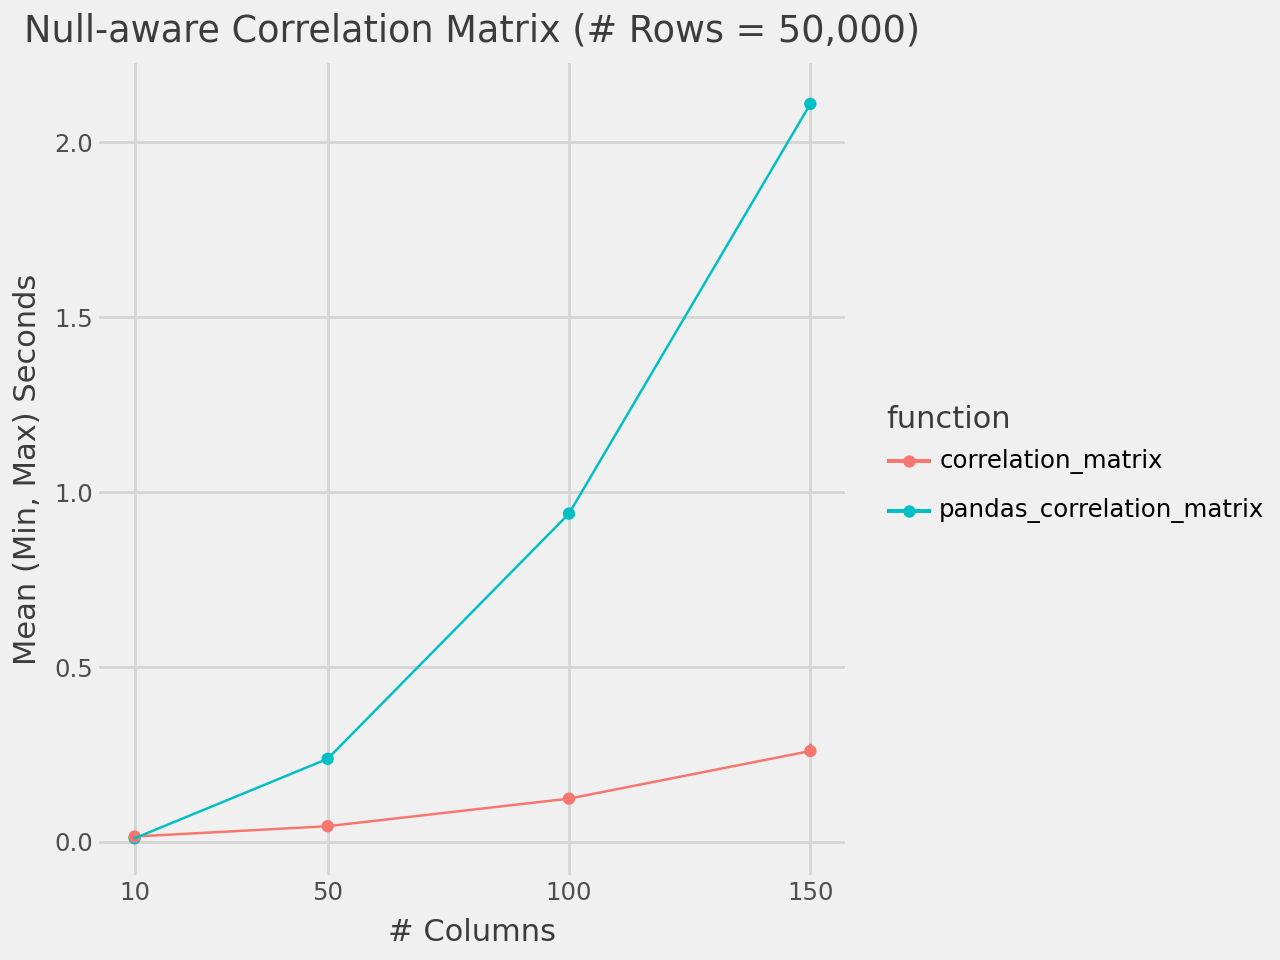

In [5]:
tmp = (
    df.filter(pl.col("group").eq("correlation_matrix"))
    .with_columns(pl.col("parameters").str.json_decode())
    .unnest("parameters")
    .with_columns(pl.col("n_rows").max().alias("_max_rows"))
)

(
    compare_over_sizes(
        tmp.filter(pl.col("n_rows").eq(pl.col("_max_rows"))).rename({"n_cols": "size"})
    )
    + p9.labs(x="# Columns")
    + p9.ggtitle(
        f"Null-aware Correlation Matrix (# Rows = {tmp['_max_rows'].item(0):,})"
    )
)

# Metrics

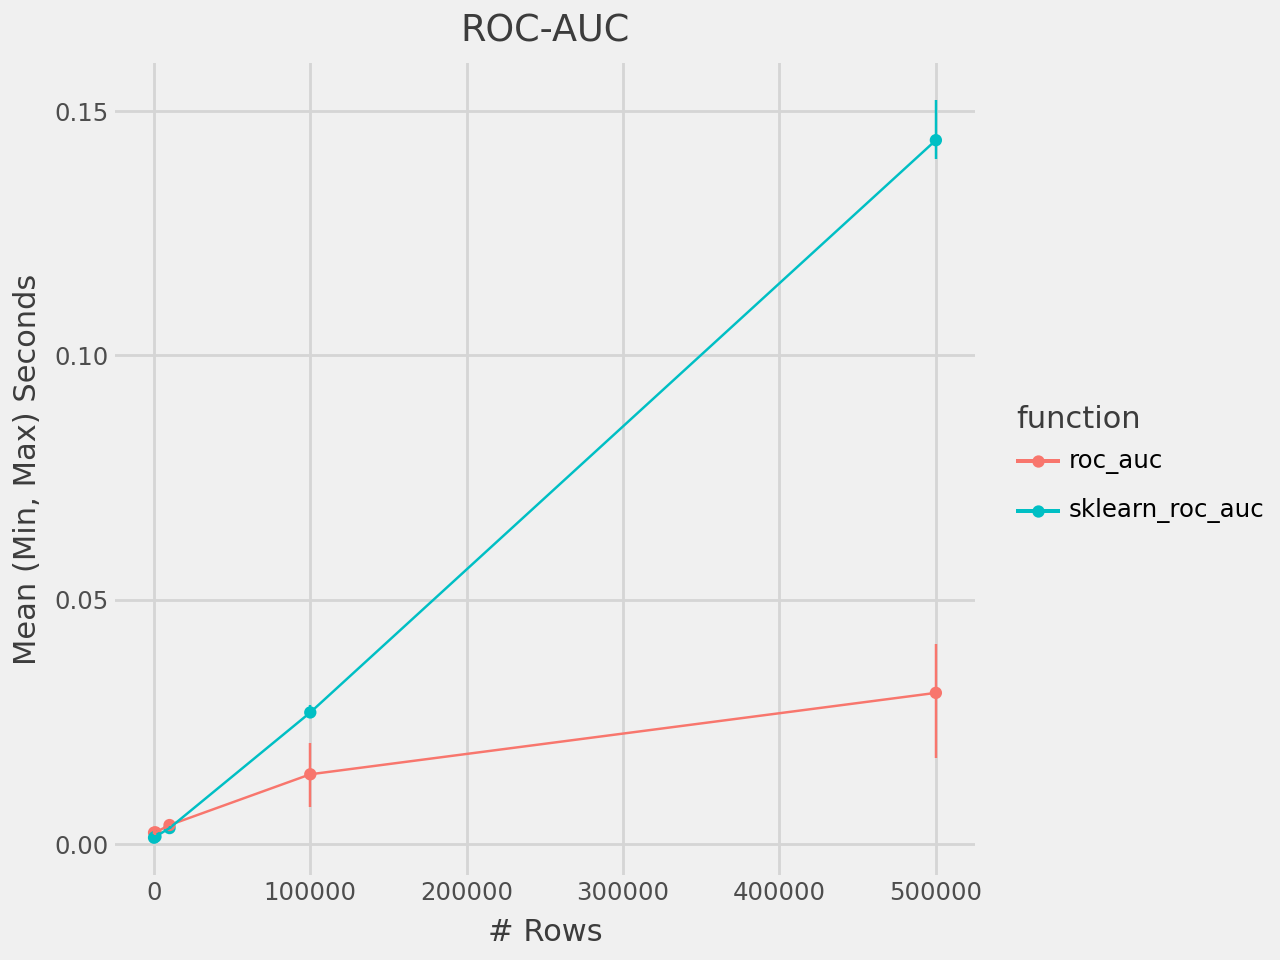

In [6]:
(
    compare_over_sizes(
        df.filter(pl.col("group").eq("roc_auc"))
        .with_columns(pl.col("parameters").str.json_decode())
        .unnest("parameters")
        .rename({"n": "size"}),
        label_all_sizes=False,
    )
    + p9.labs(x="# Rows")
    + p9.ggtitle("ROC-AUC")
)

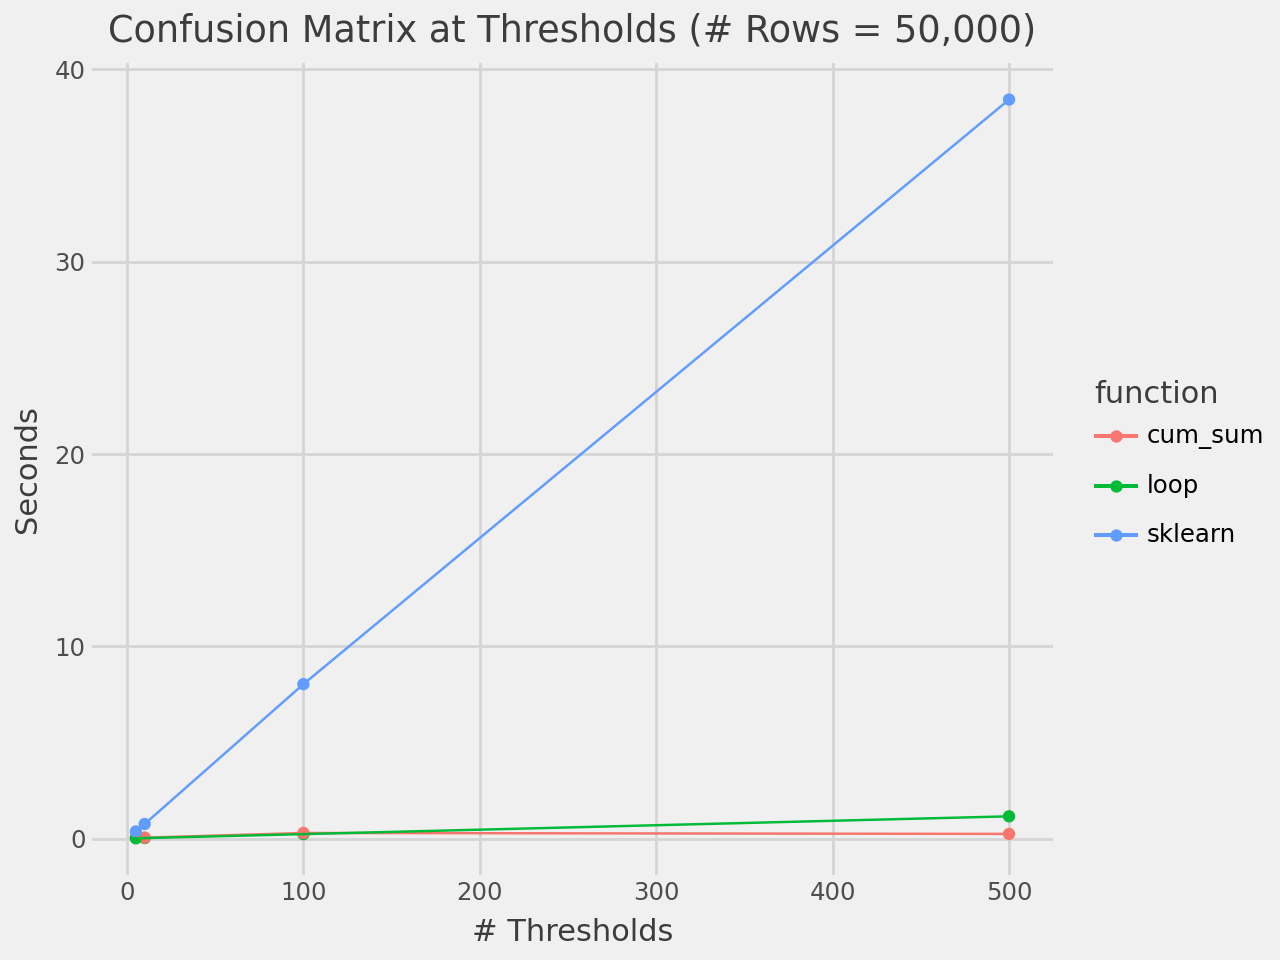

In [7]:
tmp = (
    df.filter(pl.col("group").eq("confusion_matrix_at_thresholds"))
    .with_columns(pl.col("parameters").str.json_decode())
    .unnest("parameters")
    .with_columns(
        pl.when(pl.col("strategy").is_not_null())
        .then(pl.format("{}{}", pl.col("function"), pl.col("strategy")))
        .otherwise(pl.col("function"))
        .str.replace_all("confusion_matrix_at_thresholds", "")
        .str.strip_chars_end("_")
        .alias("function"),
        pl.col("n").max().alias("_max_n"),
        # pl.col("mean", "min", "max").log1p(),
    )
    .filter(pl.col("n").eq(pl.col("_max_n")))
    .rename({"n_thresholds": "size"})
)

(
    compare_over_sizes(
        tmp,
        label_all_sizes=False,
    )
    + p9.labs(x="# Thresholds", y="Seconds")
    + p9.ggtitle(f"Confusion Matrix at Thresholds (# Rows = {tmp['_max_n'].item(0):,})")
)

In [8]:
(
    tmp.filter(pl.col("size").eq(pl.col("size").max()))
    .with_columns(
        pl.repeat(
            pl.col("mean").filter(pl.col("function").eq("sklearn")).first(), pl.len()
        ).alias("ref_mean")
    )
    .with_columns(pl.col("ref_mean").truediv(pl.col("mean")).alias("speedup"))
    .select("function", "mean", "speedup")
)

function,mean,speedup
str,f64,f64
"""sklearn""",38.437524,1.0
"""loop""",1.166487,32.951527
"""cum_sum""",0.251851,152.62007


# Bootstrap

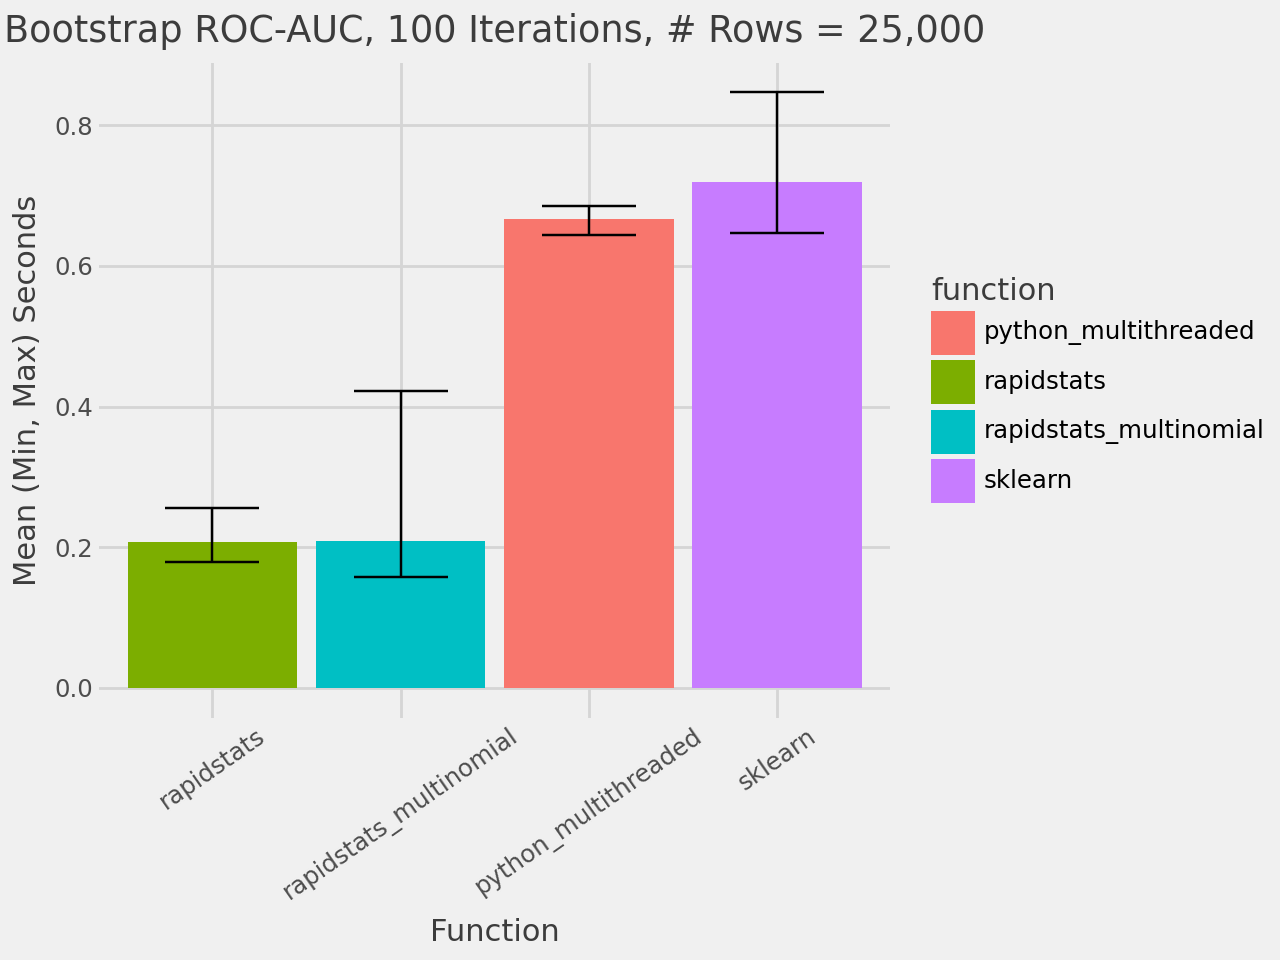

In [ ]:
tmp = df.filter(pl.col("group").eq("bootstrap_roc_auc")).with_columns(
    pl.col("function")
    .str.replace_all("bootstrap_roc_auc", "")
    .str.strip_suffix("_")
    .replace(
        {
            "bootstrap_poisson_roc_auc": "rapidstats_poisson",
            "bootstrap_multinomial_roc_auc": "rapidstats_multinomial",
        },
    )
)

(
    p9.ggplot(
        tmp,
        p9.aes(x="reorder(function, mean)", y="mean"),
    )
    + p9.geom_col(p9.aes(fill="function"))
    + p9.geom_errorbar(p9.aes(ymin="min", ymax="max"))
    + p9.labs(x="Function", y="Mean (Min, Max) Seconds")
    + p9.ggtitle("Bootstrap ROC-AUC, 100 Iterations, # Rows = 25,000")
    + p9.theme_538()
    + p9.theme(axis_text_x=p9.element_text(angle=35))
)

In [10]:
(
    tmp.with_columns(
        pl.repeat(
            pl.col("mean").filter(pl.col("function").eq("sklearn")).first(), pl.len()
        ).alias("ref_mean")
    )
    .with_columns(pl.col("ref_mean").truediv(pl.col("mean")).alias("speedup"))
    .select("function", "mean", "speedup")
)

function,mean,speedup
str,f64,f64
"""rapidstats""",0.207977,3.45527
"""sklearn""",0.718617,1.0
"""python_multithreaded""",0.665938,1.079105
"""rapidstats_multinomial""",0.208568,3.445474


# Bootstrap Confusion Matrix at Thresholds

In [11]:
df.filter(pl.col("group").eq("bootstrap_confusion_matrix_at_thresholds"))

function,parameters,mean,min,max,median,std,p5,p95,p1,p99,repeat,number,warmups,garbage_collection,group,timestamp,branch,commit,version,python_version,available_cpus,available_ram,platform,processor
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,bool,str,f64,str,str,str,str,i64,str,str,str
"""bootstrap_multinomial_confusio…",null,2.31271,2.282213,2.357411,2.30057,0.031391,2.282213,2.357411,2.282213,2.357411,5,1,1,true,"""bootstrap_confusion_matrix_at_…",1.7567e9,"""master ""","""0b09792ef808c1f6f4b4794f559323…","""0.3.0""","""3.13.3 (main, Apr 9 2025, 04:…",16,"""1.11GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64"""
"""bootstrap_confusion_matrix_at_…",null,2.406517,2.327199,2.529883,2.379234,0.080589,2.327199,2.529883,2.327199,2.529883,5,1,1,true,"""bootstrap_confusion_matrix_at_…",1.7567e9,"""master ""","""0b09792ef808c1f6f4b4794f559323…","""0.3.0""","""3.13.3 (main, Apr 9 2025, 04:…",16,"""1.11GB""","""Linux-5.15.123.1-microsoft-sta…","""x86_64"""
